In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
fb = pd.read_csv('./results_year.csv')
fb.head()

,country,year,neutral,home_win,away_win,games_played,goal_diff,win_rate
0,Austria,2010,0,1,0,4,-1,0.250000
1,Austria,2011,0,1,0,6,-8,0.166667
2,Austria,2012,0,1,0,3,1,0.333333
3,Austria,2013,0,1,0,4,-5,0.250000
4,Austria,2014,0,0,0,1,0,0.000000


In [3]:
sj = pd.read_csv('./jobs/sports_jobs.csv')
sj.head()

,country,year,employed
0,Austria,2011,251000
1,Austria,2012,240000
2,Austria,2013,258000
3,Austria,2014,278000
4,Austria,2015,359000


In [4]:
imm = pd.read_csv('./immigration/immigration.csv')
imm.head()

,Unnamed: 0,country,year,immigration
0,0,Belgium,2010,135281.0
1,1,Bulgaria,2010,NaN
2,2,Czechia,2010,48317.0
3,3,Denmark,2010,52236.0
4,4,Germany,2010,404055.0


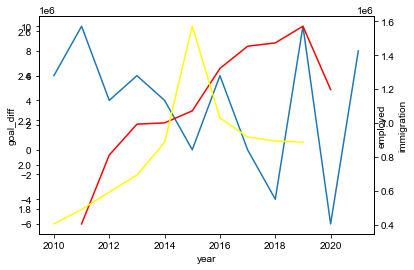

In [5]:
# clean data
country = "Germany"
s_fb = fb[(fb["country"] == country)]
s_sj = sj[sj["country"] == country]
s_imm = imm[imm["country"] == country]
# fball plot
lp1 = sns.lineplot(data=s_fb, x="year", y="goal_diff", hue="country")
lp1.legend_ = None
# employment plot
ax2 = plt.twinx()
lp2 = sns.lineplot(data=s_sj, x="year", y="employed", palette=["red"], hue="country", ax=ax2)
lp2.legend_ = None
# immigration plot
ax3 = plt.twinx()
lp3 = sns.lineplot(data=s_imm, x="year", y="immigration", palette=["yellow"], hue="country", ax=ax3)
lp3.legend_ = None
# change size
sns.set(rc={'figure.figsize':(17,13)})
lp2.grid(False)



# Guide from:
> https://builtin.com/data-science/time-series-python

In [6]:
df = pd.merge(pd.merge(imm, fb, on=["country", "year"]), sj, on=["country", "year"])
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,country,year,immigration,neutral,home_win,away_win,games_played,goal_diff,win_rate,employed
0,Belgium,2011,147377.0,0,1,1,6,1,0.333333,235000
1,Bulgaria,2011,NaN,0,0,1,1,1,1.000000,102000
2,Denmark,2011,52833.0,0,3,2,5,8,1.000000,257000
3,Germany,2011,489422.0,0,3,1,6,10,0.666667,1733000
4,Estonia,2011,3709.0,0,0,1,2,-2,0.500000,34000


In [7]:
df = df[df["country"] == "Austria"].dropna()
df['date'] = pd.to_datetime(df['year'], format='%Y')
df.index = df['date']
del df['date']
del df['country']
df

,year,immigration,neutral,home_win,away_win,games_played,goal_diff,win_rate,employed
date,,,,,,,,,
2011-01-01,2011,82230.0,0,1,0,6,-8,0.166667,251000
2012-01-01,2012,91557.0,0,1,0,3,1,0.333333,240000
2013-01-01,2013,101866.0,0,1,0,4,-5,0.250000,258000
2014-01-01,2014,116262.0,0,0,0,1,0,0.000000,278000
2015-01-01,2015,166323.0,0,0,1,1,3,1.000000,359000
2016-01-01,2016,129509.0,2,1,0,5,-3,0.200000,279000
2017-01-01,2017,111801.0,0,0,0,1,0,0.000000,263000
2018-01-01,2018,105633.0,0,3,1,5,8,0.800000,241000
2019-01-01,2019,109167.0,0,2,1,6,6,0.500000,309000


<AxesSubplot:xlabel='date', ylabel='goal_diff'>

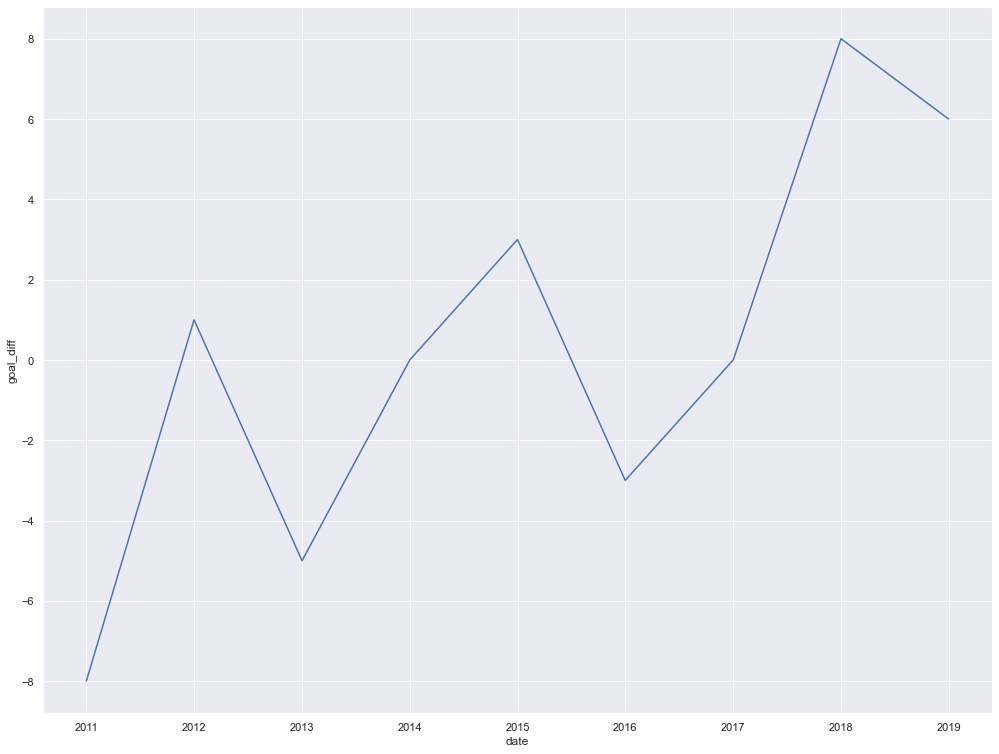

In [8]:
sns.lineplot(data=df, x="date", y="goal_diff")

<AxesSubplot:xlabel='date', ylabel='goal_diff'>

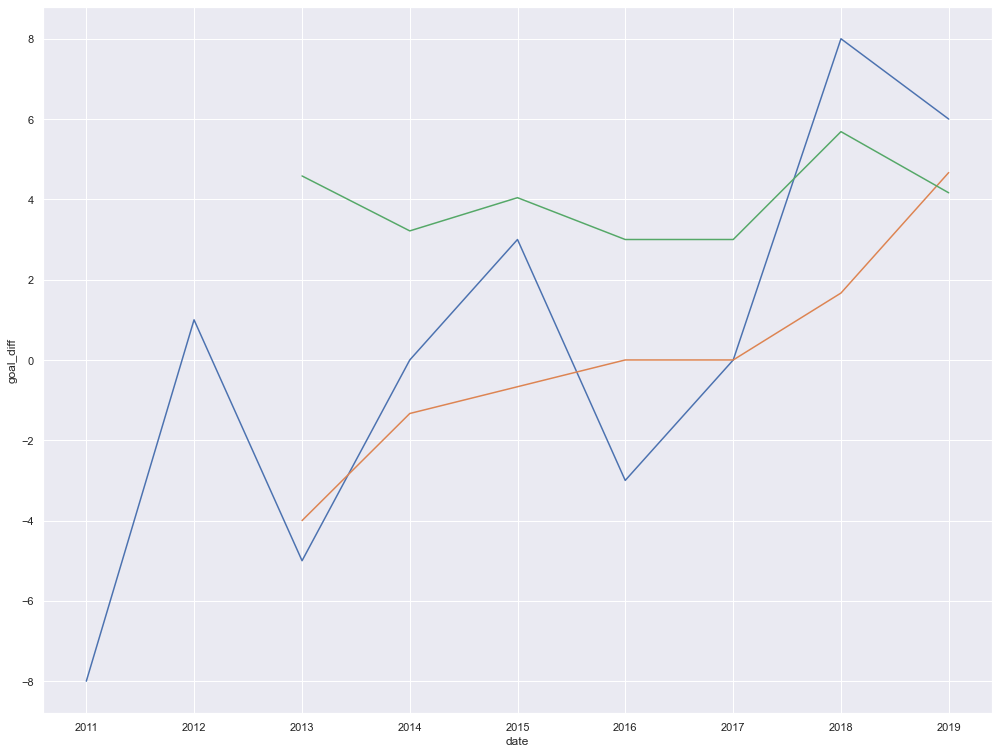

In [9]:
rolling_mean = df.rolling(3).mean()
rolling_std = df.rolling(3).std()
sns.lineplot(data=df, x="date", y="goal_diff")
sns.lineplot(data=rolling_mean, x="date", y="goal_diff")
sns.lineplot(data=rolling_std, x="date", y="goal_diff")


In [10]:
adft = adfuller(df["goal_diff"], autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)
# "We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value"

     Values                       Metric
0 -2.327793              Test Statistics
1  0.163161                      p-value
2  0.000000             No. of lags used
3  8.000000  Number of observations used
4 -4.665186          critical value (1%)
5 -3.367187          critical value (5%)
6 -2.802961         critical value (10%)


In [11]:
autocorrelation_lag1 = df['goal_diff'].autocorr(lag=1)
print("One year lag: ", autocorrelation_lag1)

One year lag:  0.20733582861790592


In [12]:
# Doesn't work, requires 14 observations
#decompose = seasonal_decompose(df['goal_diff'],model='additive', period=7)
#decompose.plot()
#plt.show()

C:\Users\Nick\AppData\Local\Temp/ipykernel_14648/3192544242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['goal_diff']
C:\Users\Nick\AppData\Local\Temp/ipykernel_14648/3192544242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['goal_diff']


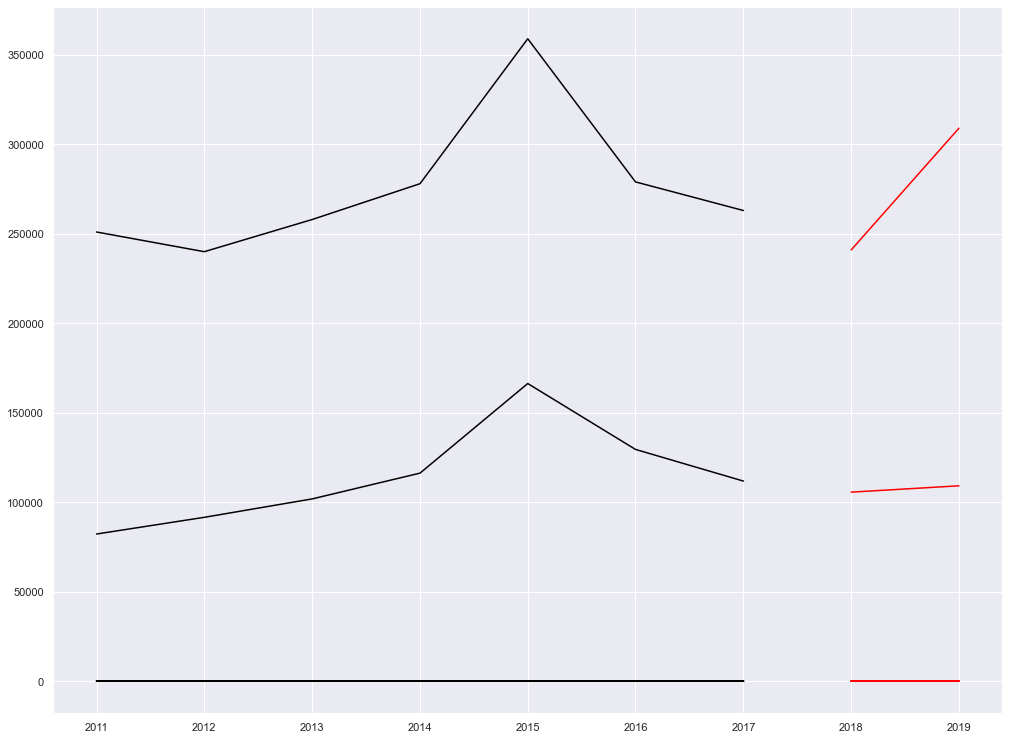

In [13]:
train = df[df['year'] < 2018]
train['train'] = train['goal_diff']
del train['year']
del train['goal_diff']
test = df[df['year'] >= 2018]
test['test'] = test['goal_diff']
del test['year']
del test['goal_diff']

plt.plot(train, color = "black")
plt.plot(test, color = "red")
sns.set()
plt.show()

In [14]:
train = train["train"]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index = test.index, columns=['Prediction'])
forecast.head()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.817, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41.540, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.826, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.019, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.509 seconds


,Prediction
date,
2018-01-01,0.0
2019-01-01,0.0
